In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the dataset

In [4]:
x_train = pd.read_csv('/content/drive/MyDrive/Project/Accenture Supply Chain/Dataset/x_train_adasyn_c.csv')
x_test = pd.read_csv('/content/drive/MyDrive/Project/Accenture Supply Chain/Dataset/x_test_adasyn_c.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Project/Accenture Supply Chain/Dataset/y_train_adasyn.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Project/Accenture Supply Chain/Dataset/y_test_adasyn.csv')

In [5]:
y_test1 = y_test["late_order"]
y_train1 = y_train["late_order"]

Helper function for confusion matrix

In [6]:
### Helper method
# You may consider changeing the colour scheme in practice

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
# empty dataframe for storing performance matrics
metrics = pd.DataFrame(np.zeros(shape = (5, 4)))
metrics.columns = ['models', 'accuracy', 'f1 score', 'precision']

In [8]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.4 MB/s eta 0:00:00


In [10]:
import shap

1) Random Forest Baseline

--------RF--------
Correctly classified instances: 45053
Accuracy Score is 0.86097
Recall Score is 0.8121
Precision Score is 0.90186
F1 Score is 0.85463
       0      1
0  23668   2327
1   4948  21385
[[23668  2327]
 [ 4948 21385]]


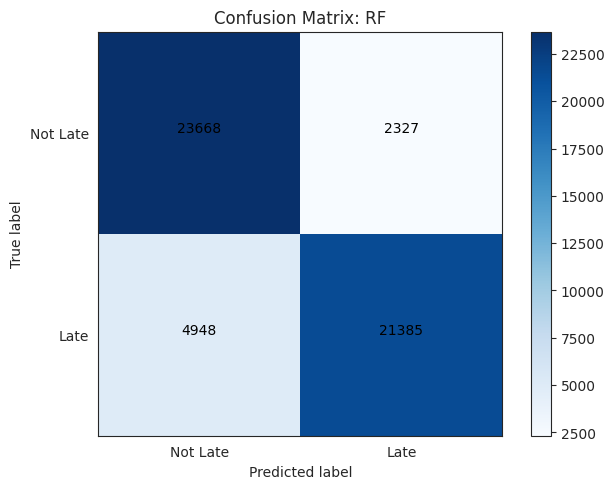

In [11]:
print("--------RF--------")
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state = 42)
rf_model.fit(x_train, y_train1)


y_predict =rf_model.predict(x_test)
#print(y_predict)
#print(y_test_label)

print(f'Correctly classified instances: {sum(y_predict == y_test1)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test1, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test1, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test1, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test1, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test1,y_predict)))

sns.set_style('white') 
class_names = ['Not Late','Late']
plot_confusion_matrix(confusion_matrix(y_test1,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: RF')

metrics.iloc[0,:] = ['RF',accuracy_score(y_test1, y_predict),
                     f1_score(y_test1, y_predict),
                     precision_score(y_test1,y_predict)]

ROC Score for Random Forest

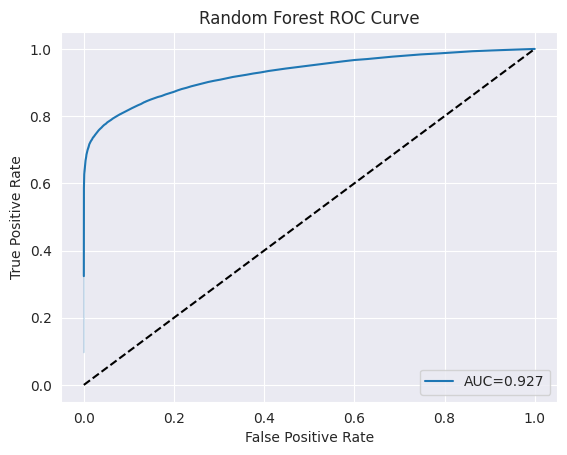

In [12]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# assume you have a trained classifier clf and test data X_test, y_test
y_score = rf_model.predict_proba(x_test)[:, 1] # get the probability of positive class
fpr, tpr, _ = roc_curve(y_test1, y_score) # calculate FPR, TPR
roc_auc = auc(fpr, tpr) # calculate AUC

# plot ROC curve using Seaborn
sns.set_style('darkgrid')
sns.lineplot(x=fpr, y=tpr, label=f'AUC={roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--') # plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()

Feature Importance for the Random Forest

                   Feature  Importance
3                   weight    0.152826
0                    units    0.134756
12  customs_procedures_CRF    0.064371
9                3pl_v_002    0.064264
1               first_mile    0.055210
2                last_mile    0.049764
11               3pl_v_004    0.046736
4        material_handling    0.046428
13  customs_procedures_DTD    0.042860
7    origin_port_Rotterdam    0.037637


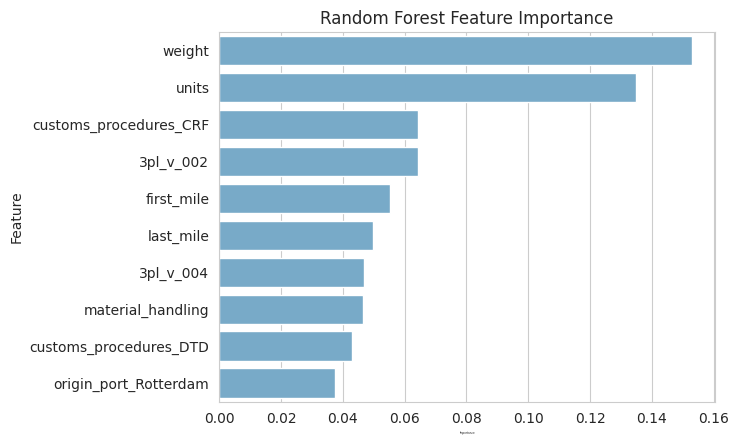

In [13]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = rf_model.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply plot for the Random Forest

Permutation explainer: 201it [01:41,  1.86it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


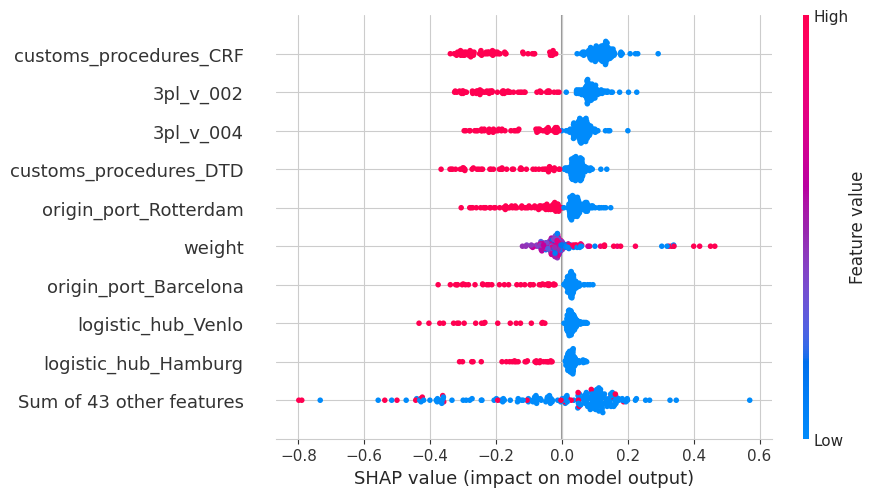

In [14]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(rf_model.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

2) LGBM

In [15]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122098 entries, 0 to 122097
Data columns (total 52 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   units                    122098 non-null  int64  
 1   first_mile               122098 non-null  float64
 2   last_mile                122098 non-null  float64
 3   weight                   122098 non-null  int64  
 4   material_handling        122098 non-null  int64  
 5   origin_port_Athens       122098 non-null  int64  
 6   origin_port_Barcelona    122098 non-null  int64  
 7   origin_port_Rotterdam    122098 non-null  int64  
 8   3pl_v_001                122098 non-null  int64  
 9   3pl_v_002                122098 non-null  int64  
 10  3pl_v_003                122098 non-null  int64  
 11  3pl_v_004                122098 non-null  int64  
 12  customs_procedures_CRF   122098 non-null  int64  
 13  customs_procedures_DTD   122098 non-null  int64  
 14  cust

--------LGBM--------


Using categorical_feature in Dataset.


Correctly classified instances: 45933
Accuracy Score is 0.87779
Recall Score is 0.80709
Precision Score is 0.94173
F1 Score is 0.86923
       0      1
0  24680   1315
1   5080  21253
[[24680  1315]
 [ 5080 21253]]


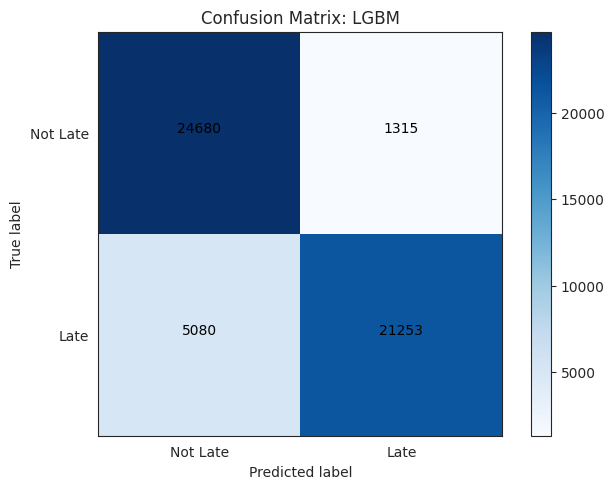

In [16]:
print("--------LGBM--------")
import lightgbm as lgb
lgbm_model = lgb.LGBMClassifier(random_state = 42)
cat_features = list(range(4, 51))
lgbm_model.fit(x_train, y_train1,categorical_feature=cat_features)

y_predict = lgbm_model.predict(x_test)

print(f'Correctly classified instances: {sum(y_predict == y_test1)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test1, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test1, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test1, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test1, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test1,y_predict)))

sns.set_style('white') 
class_names = ['Not Late','Late']
plot_confusion_matrix(confusion_matrix(y_test1,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: LGBM')

metrics.iloc[0,:] = ['LGBM',accuracy_score(y_test1, y_predict),
                     f1_score(y_test1, y_predict),
                     precision_score(y_test1,y_predict)]

ROC Score for LGBM

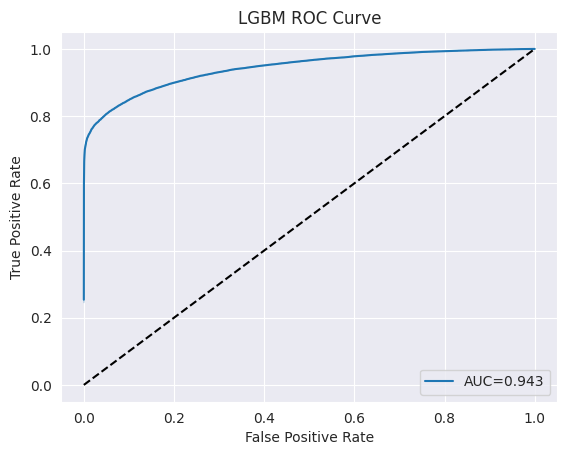

In [17]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# assume you have a trained classifier clf and test data X_test, y_test
y_score = lgbm_model.predict_proba(x_test)[:, 1] # get the probability of positive class
fpr, tpr, _ = roc_curve(y_test1, y_score) # calculate FPR, TPR
roc_auc = auc(fpr, tpr) # calculate AUC

# plot ROC curve using Seaborn
sns.set_style('darkgrid')
sns.lineplot(x=fpr, y=tpr, label=f'AUC={roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--') # plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM ROC Curve')
plt.legend(loc='lower right')
plt.show()

Feature Importance for LGBM

                   Feature  Importance
3                   weight         831
0                    units         359
1               first_mile         247
2                last_mile         185
4        material_handling          84
7    origin_port_Rotterdam          62
12  customs_procedures_CRF          56
9                3pl_v_002          53
11               3pl_v_004          48
14  customs_procedures_DTP          48


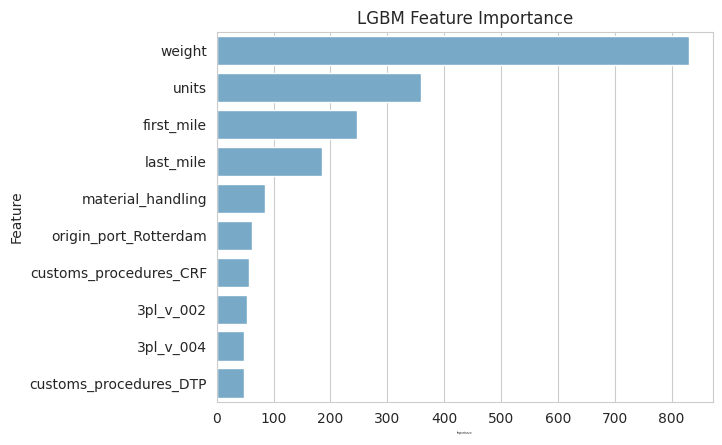

In [18]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = lgbm_model.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('LGBM Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply Plot for LGBM

Permutation explainer: 201it [00:31,  4.41it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


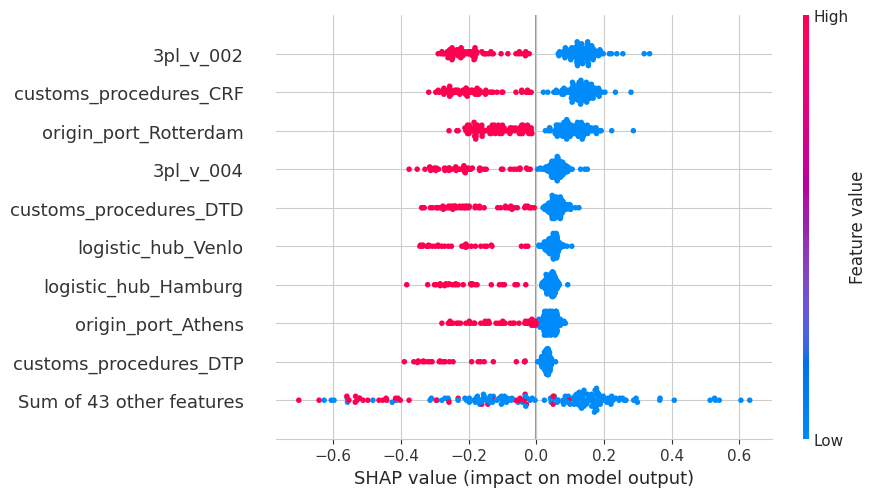

In [19]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(lgbm_model.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

3) XGBOOST

--------XGBoost--------
Correctly classified instances: 45761
Accuracy Score is 0.8745
Recall Score is 0.81176
Precision Score is 0.92996
F1 Score is 0.86685
       0      1
0  24385   1610
1   4957  21376
[[24385  1610]
 [ 4957 21376]]


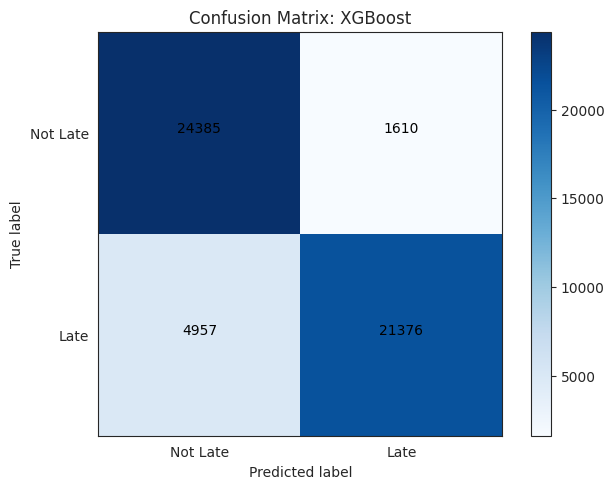

In [20]:
from xgboost import XGBClassifier
print("--------XGBoost--------")
xgb = XGBClassifier(booster = 'gbtree', seed = 42)
xgb.fit(x_train, y_train1)

y_predict = xgb.predict(x_test)

print(f'Correctly classified instances: {sum(y_predict == y_test1)}')
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test1, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test1, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test1, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test1, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test1,y_predict)))

sns.set_style('white') 
class_names = ['Not Late','Late']
plot_confusion_matrix(confusion_matrix(y_test1,y_predict),
                      classes= class_names, normalize = False, 
                      title='Confusion Matrix: XGBoost')

ROC Curve for XGBOOST

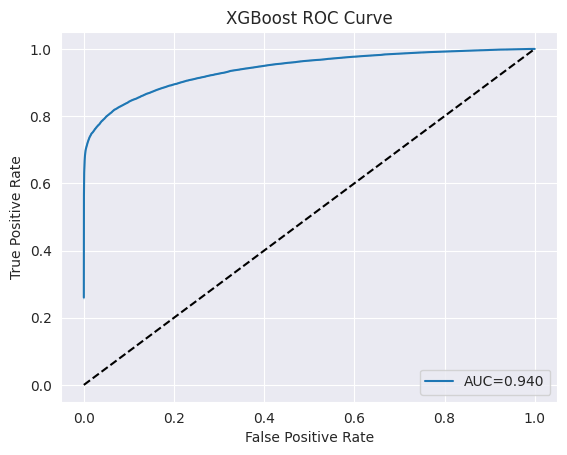

In [21]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# assume you have a trained classifier clf and test data X_test, y_test
y_score = xgb.predict_proba(x_test)[:, 1] # get the probability of positive class
fpr, tpr, _ = roc_curve(y_test1, y_score) # calculate FPR, TPR
roc_auc = auc(fpr, tpr) # calculate AUC

# plot ROC curve using Seaborn
sns.set_style('darkgrid')
sns.lineplot(x=fpr, y=tpr, label=f'AUC={roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--') # plot the random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

Feature Importance for XGBoost

                   Feature  Importance
14  customs_procedures_DTP    0.131947
11               3pl_v_004    0.114625
10               3pl_v_003    0.091964
8                3pl_v_001    0.084539
13  customs_procedures_DTD    0.077328
9                3pl_v_002    0.063067
7    origin_port_Rotterdam    0.059648
5       origin_port_Athens    0.056261
12  customs_procedures_CRF    0.047611
6    origin_port_Barcelona    0.020032


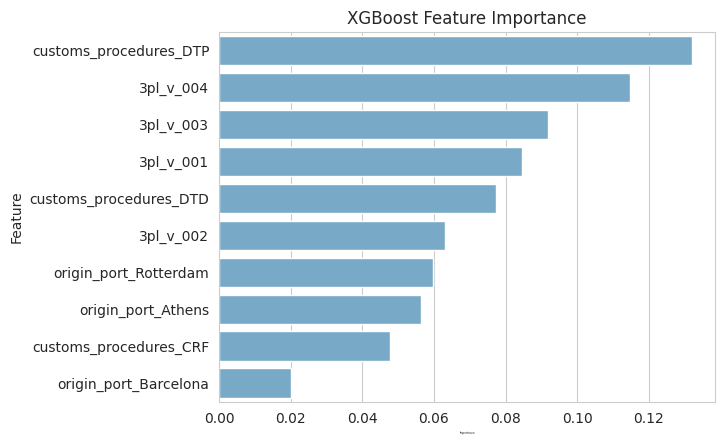

In [22]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = xgb.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply plot for XGBoost

Permutation explainer: 201it [00:17,  4.46it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


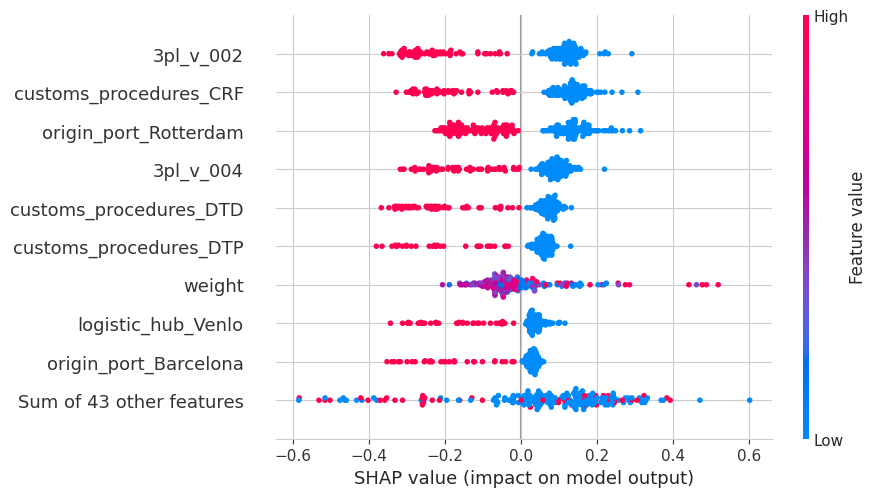

In [23]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=200, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(xgb.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)